In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Reading in the data
data = np.load('../data/same_preset_MC_100_5_4.npz.npy')
trueCls = np.load('../data/same_preset_MC_100_5_4_reference_classes.npy')
data.shape

(100, 5, 4)

In [3]:
#Inferring the number of classes and data length
numData = data.shape[0]
numExperts = data.shape[1]
numClasses = data.shape[2]

In [4]:
def swap_class(z, row_idx, numClasses):
    new_z = np.copy(z)
    classes = list(range(numClasses))
    old_class = np.where(z[row_idx,:] == 1)[0][0]
    #Removing the old class
    del classes[old_class]
    new_class = np.random.choice(classes)
    new_row = np.zeros(numClasses)
    new_row[new_class] = 1.
    new_z[row_idx] = new_row
    return new_z

In [5]:
def gen_confusion_matrix(z, data):
    numClasses = data.shape[2]
    numExperts = data.shape[1]
    numData = data.shape[0]
    confMat = 0.01*np.ones((numExperts, numClasses, numClasses))
    for data_idx in range(numData):
        dat = data[data_idx]
        observed_cls = z[data_idx,:]
        class_num = np.where(observed_cls == 1)[0][0]
        for exp_idx in range(numExperts):
            confMat[exp_idx,class_num,:] += dat[exp_idx,:]
    confMat = confMat/confMat.sum(axis=(2))[:,:,np.newaxis]
    return confMat

In [6]:
def mc_likelihood(data, z, confMatArray):
    log_like = 0
    numData = data.shape[0]
    numExperts = data.shape[1]
    numClasses = data.shape[2]
    for data_idx in range(numData):
        data_val = data[data_idx]
        z_val = z[data_idx]
        obs_val = np.where(z_val == 1)[0][0]
        """
        for cls_idx in range(numClasses):
            log_like += z_val[cls_idx]*( \
                    np.sum(np.multiply(np.log(confMatArray[:, obs_val, cls_idx]), \
                                data_val[:, cls_idx])))
        """
        log_like += np.sum(np.multiply(z_val, np.sum(np.multiply(np.log(confMatArray[:, obs_val, :]), \
                                data_val), axis=0)))
    return log_like

In [7]:
def compute_pi(z, numData):
    return z.sum(axis=0)/numData

In [8]:
"""
data_num = np.random.choice(range(numClasses), size=numData)
z = np.eye(numClasses)[data_num]
"""
inferred_labels = np.argmax(data.sum(axis=1), axis=1)
z = np.eye(numClasses)[inferred_labels]
confMat = gen_confusion_matrix(z, data)
pi = compute_pi(z, numData)

In [9]:
def simulated_annealing_mc(z, confMat, data, starting_temp=10, reanneal=0.001, num_iterations=100):
    #Inferring the number of classes and data length
    numData = data.shape[0]
    numExperts = data.shape[1]
    numClasses = data.shape[2]
    numAccepts = 0
    temp = starting_temp
    likelihood_trace = []
    best_likelihood_trace = []
    temp_trace = []
    best_start = z
    best_conf = confMat
    best_lik = -np.inf
    for i in range(num_iterations):
        swap_idx = np.random.choice(range(numData), size=1, replace=False)[0]
        z_new = swap_class(z, swap_idx, numClasses)
        confMatNew = gen_confusion_matrix(z_new, data)
        new_lik = mc_likelihood(data, z_new, confMatNew)
        old_lik = mc_likelihood(data, z, confMat)
        u = np.random.uniform()
        prob = min([1, np.exp((new_lik - old_lik)/temp)])
        #print prob, u
        #Always accepting if the likelihood increases
        if new_lik > old_lik:
            z = z_new
            confMat = confMatNew
            if new_lik > best_lik:
                best_lik = new_lik
                best_start = z_new
                best_conf = confMat
            likelihood_trace.append(new_lik)
            numAccepts += 1
        #Accepting based on the probability if the error does not reduce
        elif prob >= u:
            z = z_new
            confMat = confMatNew
            if new_lik > best_lik:
                best_lik = new_lik
                best_start = z
                best_conf = confMat
            likelihood_trace.append(new_lik)
            numAccepts += 1
        else:
            likelihood_trace.append(old_lik)
        #Reducing temperature every 10th iteration
        if i%10 == 0:
            temp = temp*0.99
        if (i+1)%1000 == 0:
            print "#",
        #Reannealing if the temperature is too low
        if temp < reanneal:
            temp = 10
        temp_trace.append(temp)
        best_likelihood_trace.append(best_lik)
    return likelihood_trace, best_likelihood_trace, temp_trace, best_start, best_lik, best_conf, numAccepts

In [10]:
likelihood_trace, best_likelihood_trace, temp_trace, best_start, best_lik, best_conf, numAccepts =\
simulated_annealing_mc(z, confMat, data, num_iterations=10000)

# # # # # # # # # #


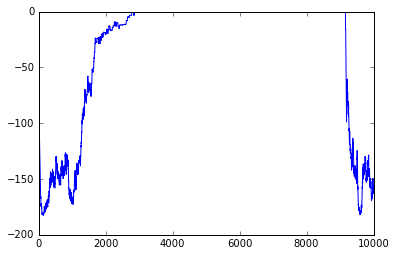

In [14]:
plt.plot(likelihood_trace)

In [12]:
print "Accuracy :", np.sum(np.argmax(best_start, axis=1) == trueCls)*100/numData, "%"

Accuracy : 0 %


In [13]:
best_conf[0]

array([[  4.99001996e-04,   2.00099800e-01,   4.49600798e-01,
          3.49800399e-01],
       [  3.56990014e-01,   3.56633381e-04,   4.28316690e-01,
          2.14336662e-01],
       [  2.96227811e-01,   2.59245562e-01,   3.69822485e-04,
          4.44156805e-01],
       [  1.60143770e-01,   4.79632588e-01,   3.59824281e-01,
          3.99361022e-04]])

In [15]:
best_lik

0.0